# Markov chain analysis of the US airport network

One way to view the airline transportation infrastructure is in the form of a directed _network_ or _graph_, in which vertices are airports and edges are the direct-flight segments that connect them. For instance, if there is a direct flight from Atlanta's Hartsfield-Jackson International Airport ("ATL") to Los Angeles International Airport ("LAX"), then the airport network would have a directed edge from ATL to LAX.

Given the airport network, one question we might ask is, which airports are most critical to disruption of the overall network? That is, if an airport is shut down, thereby leading to all inbound and outbound flights being cancelled, will that catastrophic event have a big impact or a small impact on the overall network?

You would expect "importance" to be related to whether an airport has lots of inbound or outgoing connections. In graph lingo, that's also called the _degree_ of a vertex or node. But if there are multiple routes that can work around a highly connected hub (i.e., a vertex with a high indegree or outdegree), that might not be the case. So let's try to use a PageRank-like scheme to see what we get and compare that to looking at degree.

As it happens, the US Bureau of Transportation Statistics collects data on all flights originating or arriving in the United States. In this notebook, you'll use this data to build an airport network and then use Markov chain analysis to rank the networks by some measure of "criticality."

> Sources: This notebook is adapted from the following: https://www.mongodb.com/blog/post/pagerank-on-flights-dataset. The dataset you will use was taken from the repository available here: https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236

## The formal analysis problem

Let's model the analysis problem as follows.

Consider a "random flyer" to be a person who arrives at an airport $i$, and then randomly selects any direct flight that departs from $i$ and arrives at $j$. We refer to the direct flight from $i$ to $j$ as the _flight segment_ $i \rightarrow j$. Upon arriving at $j$, the flyer repeats the process of randomly selecting a new segment, $j \rightarrow k$. He or she repeats this process forever.

Let $x_i(t)$ be the probability that the flyer is at airport $i$ at time $t$. Take $t$ to be an integer count corresponding to the number of flight segments that the flyer has taken so far, starting at $t=0$. Let $p_{ij}$ be the probability of taking segment $i \rightarrow j$, where $p_{ij} = 0$ means the segment $i \rightarrow j$ is unavailable or does not exist. If there are $n$ airports in all, numbered from $0$ to $n-1$, then the probability that the flyer will be at airport $i$ at time $t+1$, given all the probabilities at time $t$, is

$$
  x_i(t+1) = \sum_{j=0}^{n-1} p_{ji} \cdot x_j(t).
$$

Let $P \equiv [p_{ij}]$ be the matrix of transition probabilities and $x(t) = [x_i(t)]$ the column vector of prior probabilities. Then we can write the above more succinctly for all airports as the matrix-vector product,

$$
  x(t+1) = P^T x(t).
$$

Since $P$ is a probability transition matrix then there exists a steady-state distribution, $x^*$, which is the limit of $x(t)$ as $t$ goes to infinity:

$$\displaystyle \lim_{t \rightarrow \infty} x(t) = x^* \equiv [x_i^*].$$

The larger $x_i^*$, the more likely it is that the random flyer is to be at airport $i$ in the steady state. Therefore, we can take the "importance" or "criticality" of airport $i$ in the flight network to be its steady-state probability, $x_i^*$.

Thus, our data pre-processing goal is to construct $P$ and our analysis goal is to compute the steady-state probability distribution, $x^*$, for a first-order Markov chain system.

## Modules you'll need

For this notebook, let's use Pandas for preprocessing the raw data and SciPy's sparse matrix libraries to implement the analysis.

> One of the cells below defines a function, `spy()`, that can be used to visualize the non-zero structure of a sparse matrix.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse

import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def spy(A, figsize=(6, 6), markersize=0.5):
    """Visualizes a sparse matrix."""
    fig = plt.figure(figsize=figsize)
    plt.spy(A, markersize=markersize)
    plt.show()

In [3]:
from IPython.display import display, Markdown # For pretty-printing tibbles

In [4]:
def canonicalize_tibble(X):
    var_names = sorted(X.columns)
    Y = X[var_names].copy()
    Y.sort_values(by=var_names, inplace=True)
    Y.reset_index(drop=True, inplace=True)
    return Y

def tibbles_are_equivalent (A, B):
    A_canonical = canonicalize_tibble(A)
    B_canonical = canonicalize_tibble(B)
    cmp = A_canonical.eq(B_canonical)
    return cmp.all().all()

## Part 0: Downloading, unpacking, and exploring the data

You'll need some data for this assignment. The following code cell will check for it in your local environment, and if it doesn't exist, attempt to download it.

In [5]:
import requests
import os
import hashlib
import io

def on_vocareum():
    return os.path.exists('.voc')

def download(file, local_dir="", url_base=None, checksum=None):
    local_file = "{}{}".format(local_dir, file)
    if not os.path.exists(local_file):
        if url_base is None:
            url_base = "https://cse6040.gatech.edu/datasets/"
        url = "{}{}".format(url_base, file)
        print("Downloading: {} ...".format(url))
        r = requests.get(url)
        with open(local_file, 'wb') as f:
            f.write(r.content)
            
    if checksum is not None:
        with io.open(local_file, 'rb') as f:
            body = f.read()
            body_checksum = hashlib.md5(body).hexdigest()
            assert body_checksum == checksum, \
                "Downloaded file '{}' has incorrect checksum: '{}' instead of '{}'".format(local_file,
                                                                                           body_checksum,
                                                                                           checksum)
    print("'{}' is ready!".format(file))
    
if on_vocareum():
    URL_BASE = "https://cse6040.gatech.edu/datasets/us-flights/"
    DATA_PATH = "../resource/asnlib/publicdata/"
else:
    URL_BASE = "https://github.com/cse6040/labs-fa17/raw/master/lab11-markov_chains/"
    DATA_PATH = ""

datasets = {'L_AIRPORT_ID.csv': 'e9f250e3c93d625cce92d08648c4bbf0',
            'L_CITY_MARKET_ID.csv': 'f430a16a5fe4b9a849accb5d332b2bb8',
            'L_UNIQUE_CARRIERS.csv': 'bebe919e85e2cf72e7041dbf1ae5794e',
            'us-flights--2017-08.csv': 'eeb259c0cdd00ff1027261ca0a7c0332',
            'flights_atl_to_lax_soln.csv': '4591f6501411de90af72693cdbcc08bb',
            'origins_top10_soln.csv': 'de85c321c45c7bf65612754be4567086',
            'dests_soln.csv': '370f4c632623616b3bf26b6f79993fe4',
            'dests_top10_soln.csv': '4c7dd7edf48c4d62466964d6b8c14184',
            'segments_soln.csv': '516a78d2d9d768d78bfb012b77671f38',
            'segments_outdegree_soln.csv': 'b29d60151c617ebafd3a1c58541477c8'
           }

for filename, checksum in datasets.items():
    download(filename, local_dir=DATA_PATH, url_base=URL_BASE, checksum=checksum)
    
print("\n(All data appears to be ready.)")

'L_AIRPORT_ID.csv' is ready!
'L_CITY_MARKET_ID.csv' is ready!
'L_UNIQUE_CARRIERS.csv' is ready!
'us-flights--2017-08.csv' is ready!
'flights_atl_to_lax_soln.csv' is ready!
'origins_top10_soln.csv' is ready!
'dests_soln.csv' is ready!
'dests_top10_soln.csv' is ready!
'segments_soln.csv' is ready!
'segments_outdegree_soln.csv' is ready!

(All data appears to be ready.)


**Airport codes.** Let's start with the airport codes.

In [6]:
airport_codes = pd.read_csv("{}{}".format(DATA_PATH, 'L_AIRPORT_ID.csv'))
airport_codes.head()

,Code,Description
0,10001,"Afognak Lake, AK: Afognak Lake Airport"
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip"
2,10004,"Lik, AK: Lik Mining Camp"
3,10005,"Little Squaw, AK: Little Squaw Airport"
4,10006,"Kizhuyak, AK: Kizhuyak Bay"


use the airport_codes data frame to figure out the integer airport codes (not the three-letter codes) for Atlanta's Hartsfield-Jackson International (ATL) and Los Angeles International (LAX). Store these codes in variables named ATL_ID and LAX_ID, respectively.

In [7]:
ATL_ID=airport_codes[airport_codes['Description'].str.contains('Hartsfield-Jackson')].Code.item()

# ATL_ID=airport_codes['Code']['Description' ]
ATL_ID

10397

**Flight segments.** Next, let's load a file that contains all of US flights that were scheduled for August 2017.

In [8]:
flights = pd.read_csv('{}{}'.format(DATA_PATH, 'us-flights--2017-08.csv'))
print("Number of flight segments: {} [{:.1f} million]".format (len(flights), len(flights)*1e-6))
del flights['Unnamed: 7'] # Cleanup extraneous column
flights.head()

Number of flight segments: 510451 [0.5 million]


,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID
0,2017-08-01,DL,2,12478,31703,14679,33570
1,2017-08-01,DL,4,12889,32211,12478,31703
2,2017-08-01,DL,6,12892,32575,14869,34614
3,2017-08-01,DL,7,14869,34614,12892,32575
4,2017-08-01,DL,10,11292,30325,13487,31650


Each row of this tibble is a _(direct) flight segment_, that is, a flight that left some origin and arrived at a destination on a certain date. As noted earlier, these segments cover a one-month period (August 2017).

**Exercise 0** (3 points). As a warmup to familiarize yourself with this dataset, complete the following exercise, which has two subparts.

First, use the `airport_codes` data frame to figure out the integer airport codes (not the three-letter codes) for Atlanta's Hartsfield-Jackson International (ATL) and Los Angeles International (LAX). Store these codes in variables named `ATL_ID` and `LAX_ID`, respectively.

Next, determine all direct flight segments that originated at ATL and traveled to LAX. Store the result in a dataframe named `flights_atl_to_lax`, which should be the corresponding subset of rows from `flights`.

In [9]:
# PART A) Define `ATL_ID` and `LAX_ID` to correspond to the
# codes in `airport_codes` for ATL and LAX, respectively.
###
### YOUR CODE HERE
ATL_ID=airport_codes[airport_codes['Description'].str.contains('Hartsfield-Jackson')].Code.item()
ATL_ID
LAX_ID=airport_codes[airport_codes['Description'].str.contains('Los Angeles International')].Code.item()
LAX_ID
###

# Print the descriptions of the airports with your IDs:
ATL_DESC = airport_codes[airport_codes['Code'] == ATL_ID]['Description'].iloc[0]
LAX_DESC = airport_codes[airport_codes['Code'] == LAX_ID]['Description'].iloc[0]
print("{}: ATL -- {}".format(ATL_ID, ATL_DESC))
print("{}: LAX -- {}".format(LAX_ID, LAX_DESC))

10397: ATL -- Atlanta, GA: Hartsfield-Jackson Atlanta International
12892: LAX -- Los Angeles, CA: Los Angeles International


In [10]:
# PART B) Construct `flights_atl_to_lax`
###
### YOUR CODE HERE
###
flights_atl_to_lax=flights[(flights['ORIGIN_AIRPORT_ID']==ATL_ID) & (flights['DEST_AIRPORT_ID']==LAX_ID)]
# Displays a few of your results
print("Your code found {} flight segments.".format(len(flights_atl_to_lax)))
display(flights_atl_to_lax.head())

Your code found 586 flight segments.


,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID
64,2017-08-01,DL,110,10397,30397,12892,32575
165,2017-08-01,DL,370,10397,30397,12892,32575
797,2017-08-01,DL,1125,10397,30397,12892,32575
806,2017-08-01,DL,1133,10397,30397,12892,32575
858,2017-08-01,DL,1172,10397,30397,12892,32575


In [11]:
# Test cell: `flights_atl_to_lax_test` (3 points)

if False:
    flights_atl_to_lax.to_csv('flights_atl_to_lax_soln.csv', index=False)
flights_atl_to_lax_soln = pd.read_csv('{}{}'.format(DATA_PATH, 'flights_atl_to_lax_soln.csv'))

assert tibbles_are_equivalent(flights_atl_to_lax, flights_atl_to_lax_soln), \
       "Sorry, your solution does not match the instructor's solution."

print("\n(Passed!)")


(Passed!)


**Aggregation.** Observe that an (origin, destination) pair may appear many times. That's because the dataset includes a row for _every_ direct flight that occurred historically and there may have been multiple such flights on a given day.

However, for the purpose of this analysis, let's simplify the problem by collapsing _all_ historical segments $i \rightarrow j$ into a single segment. Let's also do so in a way that preserves the number of times the segment occurred (i.e., the number of rows containing the segment).

To accomplish this task, the following code cell uses the [`groupby()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) function available for Pandas tables and the [`count()`](http://pandas.pydata.org/pandas-docs/stable/groupby.html) aggregator in three steps:

1. It considers just the flight date, origin, and destination columns.
2. It _logically_ groups the rows having the same origin and destination, using `groupby()`.
3. It then aggregates the rows, counting the number of rows in each (origin, destination) group.

In [2]:
flights_cols_subset = flights[['FL_DATE', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']]
segment_groups = flights_cols_subset.groupby(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID'], as_index=False)
segments = segment_groups.count()
segments.rename(columns={'FL_DATE': 'FL_COUNT'}, inplace=True)
segments.head()

NameError: name 'flights' is not defined

As a last sanity check, let's verify that the counts are all at least 1.

In [13]:
assert (segments['FL_COUNT'] > 0).all()

**Actual (as opposed to "all possible") origins and destinations.** Although there are many possible airport codes stored in the `airport_codes` dataframe (over six thousand), only a subset appear as actual origins in the data. The following code cell determines the actual origins and prints their number.

In [14]:
origins = segments[['ORIGIN_AIRPORT_ID', 'FL_COUNT']].groupby('ORIGIN_AIRPORT_ID', as_index=False).sum()
origins.rename(columns={'FL_COUNT': 'ORIGIN_COUNT'}, inplace=True)
print("Number of actual origins:", len(origins))
origins.head()

Number of actual origins: 300


,ORIGIN_AIRPORT_ID,ORIGIN_COUNT
0,10135,180
1,10140,1761
2,10141,62
3,10146,41
4,10154,176


To get an idea of what airports are likely to be the most important in our Markov chain analysis, let's rank airports by the total number of _outgoing_ segments, i.e., flight segments that originate at the airport.

**Exercise 1** (3 points). Construct a dataframe, `origins_top10`, containing the top 10 airports in descending order of outgoing segments. This dataframe should have three columns:

* `ID`: The ID of the airport
* `Count`: Number of outgoing segments.
* `Description`: The plaintext descriptor for the airport that comes from the `airport_codes` dataframe.

> _Hint_: Look up and read about `numpy.argsort()`, which you can also apply to any Pandas Series object.

In [1]:
test=(-origins.ORIGIN_COUNT).argsort()[:10]   #get the top 10 
test
test2=origins.iloc[test]
new_way=test2.merge(airport_codes, left_on='ORIGIN_AIRPORT_ID',right_on='Code',how='left') #this is the right way to do the job 
del new_way['Code']
new_way

NameError: name 'origins' is not defined

In [15]:
###
### YOUR CODE HERE
###
test=(-origins.ORIGIN_COUNT).argsort()[:10]   #get the top 10 
test
test2=origins.iloc[test].ORIGIN_AIRPORT_ID

#Question: can I create the table without a for loop?
d = []
# notice how to use iloc in different places
for i in range(10):
    d.append({'ID': test2.iloc[i].item(), 'Count': origins.iloc[test[i]].ORIGIN_COUNT.item(),
        'Description': airport_codes[airport_codes.Code==test2.iloc[i]]['Description'].item()})

result=pd.DataFrame(d)
cols=['ID','Count','Description'] # see how to control the order of columns
origins_top10=result[cols]


# Prints the top 10, according to your calculation:
origins_top10

,ID,Count,Description
0,10397,31899,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern..."
1,13930,25757,"Chicago, IL: Chicago O'Hare International"
2,11292,20891,"Denver, CO: Denver International"
3,12892,19399,"Los Angeles, CA: Los Angeles International"
4,14771,16641,"San Francisco, CA: San Francisco International"
5,11298,15977,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter..."
6,14747,13578,"Seattle, WA: Seattle/Tacoma International"
7,12889,13367,"Las Vegas, NV: McCarran International"
8,14107,13040,"Phoenix, AZ: Phoenix Sky Harbor International"
9,13487,12808,"Minneapolis, MN: Minneapolis-St Paul Internati..."


In [16]:
# Test cell: `origin_ranks_test_entries`

if False:
    origins_top10.to_csv('origins_top10_soln.csv', index=False)
origins_top10_soln = pd.read_csv('{}{}'.format(DATA_PATH, 'origins_top10_soln.csv'))

print("=== Instructor's solution ===")
display(origins_top10_soln)
    
assert tibbles_are_equivalent(origins_top10, origins_top10_soln), \
       "Your table does not have the same entries as the solution."

=== Instructor's solution ===


,ID,Count,Description
0,10397,31899,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern..."
1,13930,25757,"Chicago, IL: Chicago O'Hare International"
2,11292,20891,"Denver, CO: Denver International"
3,12892,19399,"Los Angeles, CA: Los Angeles International"
4,14771,16641,"San Francisco, CA: San Francisco International"
5,11298,15977,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter..."
6,14747,13578,"Seattle, WA: Seattle/Tacoma International"
7,12889,13367,"Las Vegas, NV: McCarran International"
8,14107,13040,"Phoenix, AZ: Phoenix Sky Harbor International"
9,13487,12808,"Minneapolis, MN: Minneapolis-St Paul Internati..."


In [17]:
# Test cell: `origin_ranks_test_order`

counts_0_9 = origins_top10['Count'].iloc[:9].values
counts_1_10 = origins_top10['Count'].iloc[1:].values
assert (counts_0_9 >= counts_1_10).all(), \
       "Are your rows sorted in descending order?"

print("\n(Passed!)")


(Passed!)


**Exercise 2** (2 points). The preceding code computed a tibble, `origins`, containing all the unique origins and their number of outgoing flights. Write some code to compute a new tibble, `dests`, which contains all unique destinations and their number of _incoming_ flights. Its columns should be named `DEST_AIRPORT_ID` (airport code) and `DEST_COUNT` (number of direct inbound segments).

The test cell that follows prints the number of unique destinations and the first few rows of your result, as well as some automatic checks.

In [18]:
###
### YOUR CODE HERE
###

dests=flights[['FL_DATE', 'DEST_AIRPORT_ID']].groupby('DEST_AIRPORT_ID',as_index=False).count()
dests.rename(columns={'FL_DATE': 'DEST_COUNT'}, inplace=True)
print("Number of unique destinations:", len(dests))
dests.head()


Number of unique destinations: 300


,DEST_AIRPORT_ID,DEST_COUNT
0,10135,179
1,10140,1763
2,10141,62
3,10146,40
4,10154,176


In [19]:
# Test cell: `dests_test`

if False:
    dests.to_csv('dests_soln.csv', index=False)
dests_soln = pd.read_csv('{}{}'.format(DATA_PATH, 'dests_soln.csv'))

assert tibbles_are_equivalent(dests, dests_soln), "Your solution does not match the instructors'."

print("\n(Passed!)")


(Passed!)


**Exercise 3** (2 points). Compute a tibble, `dests_top10`, containing the top 10 destinations (i.e., rows of `dests`) by inbound flight count. The column names should be the same as `origins_top10` and the rows should be sorted in decreasing order by count.

In [20]:
test=(-dests.DEST_COUNT).argsort()[:10]   #get the top 10 
test
test2=dests.iloc[test].DEST_AIRPORT_ID

#Question: can I create the table without a for loop?
d = []
# notice how to use iloc in different places
for i in range(10):
    d.append({'ID': test2.iloc[i].item(), 'Count': dests.iloc[test[i]].DEST_COUNT.item(),
        'Description': airport_codes[airport_codes.Code==test2.iloc[i]]['Description'].item()})

result=pd.DataFrame(d)
cols=['ID','Count','Description'] # see how to control the order of columns
dests_top10=result[cols]


# Prints the top 10, according to your calculation:
origins_top10

,ID,Count,Description
0,10397,31899,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern..."
1,13930,25757,"Chicago, IL: Chicago O'Hare International"
2,11292,20891,"Denver, CO: Denver International"
3,12892,19399,"Los Angeles, CA: Los Angeles International"
4,14771,16641,"San Francisco, CA: San Francisco International"
5,11298,15977,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter..."
6,14747,13578,"Seattle, WA: Seattle/Tacoma International"
7,12889,13367,"Las Vegas, NV: McCarran International"
8,14107,13040,"Phoenix, AZ: Phoenix Sky Harbor International"
9,13487,12808,"Minneapolis, MN: Minneapolis-St Paul Internati..."


In [21]:
###
### YOUR CODE HERE
###

print("Your computed top 10 destinations:")
dests_top10

Your computed top 10 destinations:


,ID,Count,Description
0,10397,31901,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern..."
1,13930,25778,"Chicago, IL: Chicago O'Hare International"
2,11292,20897,"Denver, CO: Denver International"
3,12892,19387,"Los Angeles, CA: Los Angeles International"
4,14771,16651,"San Francisco, CA: San Francisco International"
5,11298,15978,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter..."
6,14747,13582,"Seattle, WA: Seattle/Tacoma International"
7,12889,13374,"Las Vegas, NV: McCarran International"
8,14107,13039,"Phoenix, AZ: Phoenix Sky Harbor International"
9,13487,12800,"Minneapolis, MN: Minneapolis-St Paul Internati..."


In [22]:
# Test cell: `dests_top10_test_entries`

if False:
    dests_top10.to_csv('dests_top10_soln.csv', index=False)
dests_top10_soln = pd.read_csv('{}{}'.format(DATA_PATH, 'dests_top10_soln.csv'))

print("=== Instructor's solution ===")
display(dests_top10_soln)
    
assert tibbles_are_equivalent(dests_top10, dests_top10_soln), \
       "Your table does not have the same entries as the solution."

=== Instructor's solution ===


,ID,Count,Description
0,10397,31901,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern..."
1,13930,25778,"Chicago, IL: Chicago O'Hare International"
2,11292,20897,"Denver, CO: Denver International"
3,12892,19387,"Los Angeles, CA: Los Angeles International"
4,14771,16651,"San Francisco, CA: San Francisco International"
5,11298,15978,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter..."
6,14747,13582,"Seattle, WA: Seattle/Tacoma International"
7,12889,13374,"Las Vegas, NV: McCarran International"
8,14107,13039,"Phoenix, AZ: Phoenix Sky Harbor International"
9,13487,12800,"Minneapolis, MN: Minneapolis-St Paul Internati..."


In [23]:
# Test cell: `dests_top10_test_order`

counts_0_9 = dests_top10['Count'].iloc[:9].values
counts_1_10 = dests_top10['Count'].iloc[1:].values
assert (counts_0_9 >= counts_1_10).all(), \
       "Are your rows sorted in descending order?"

print("\n(Passed!)")


(Passed!)


The number of actual origins does equal the number of actual destinations. Let's store this value for later use.

In [24]:
n_actual = len(set(origins['ORIGIN_AIRPORT_ID']) | set(dests['DEST_AIRPORT_ID']))
print("Number of actual locations (whether origin or destination):", n_actual)

Number of actual locations (whether origin or destination): 300


## Part 1: Constructing the state-transition matrix

Now that you have cleaned up the data, let's prepare it for subsequent analysis. Start by constructing the _probability state-transition matrix_ for the airport network. Denote this matrix by $P \equiv [p_{ij}]$, where $p_{ij}$ is the conditional probability that a random flyer departs from airport $i$ and arrives at airport $j$ given that he or she is currently at airport $i$.

To build $P$, let's use SciPy's sparse matrix facilities. To do so, you will need to carry out the following two steps:

1. _Map airport codes to matrix indices._ An `m`-by-`n` sparse matrix in SciPy uses the zero-based values 0, 1, ..., `m`-1 and 0, ..., `n`-1 to refer to row and column indices. Therefore, you will need to map the airport codes to such index values.
2. _Derive weights, $p_{ij}$._ You will need to decide how to determine $p_{ij}$.

Let's walk through each of these steps next.

**Step 1: Mapping airport codes to integers.** Luckily, you already have a code-to-integer mapping, which is in the column `airport_codes['Code']` mapped to the dataframe's `index`.

As a first step, let's make note of the number of airports, which is nothing more than the largest index value.

In [25]:
n_airports = airport_codes.index.max() + 1
print("Note: There are", n_airports, "airports.")

Note: There are 6436 airports.


Next, let's add another column to `segments` called `ORIGIN_INDEX`, which will hold the id corresponding to the origin:

In [26]:
# Recall:
segments.columns

Index(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'FL_COUNT'], dtype='object')

In [27]:
len(flights)

510451

In [28]:
# Extract the `Code` column and index from `airport_codes`, storing them in
# a temporary tibble with new names, `ORIGIN_AIRPORT_ID` and `ORIGIN_INDEX`.
origin_indices = airport_codes[['Code']].rename(columns={'Code': 'ORIGIN_AIRPORT_ID'})
origin_indices['ORIGIN_INDEX'] = airport_codes.index
                               
# Since you might run this code cell multiple times, the following
# check prevents `ORIGIN_ID` from appearing more than once.
if 'ORIGIN_INDEX' in segments.columns:
    del segments['ORIGIN_INDEX']
    
# Perform the merge as a left-join of `segments` and `origin_ids`.
segments = segments.merge(origin_indices, on='ORIGIN_AIRPORT_ID', how='left')
segments.head()

,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,FL_COUNT,ORIGIN_INDEX
0,10135,10397,77,119
1,10135,11433,85,119
2,10135,13930,18,119
3,10140,10397,93,124
4,10140,10423,4,124


**Exercise 4** (1 point). Analogous to the preceding procedure, create a new column called `segments['DEST_INDEX']` to hold the integer index of each segment's _destination_.

In [29]:
###
### YOUR CODE HERE
###
dest_indices=airport_codes[['Code']].rename(columns={'Code':'DEST_AIRPORT_ID'})
dest_indices['DEST_INDEX']=airport_codes.index
segments=segments.merge(dest_indices,on='DEST_AIRPORT_ID', how='left')
# Visually inspect your result:
segments.head()

,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,FL_COUNT,ORIGIN_INDEX,DEST_INDEX
0,10135,10397,77,119,373
1,10135,11433,85,119,1375
2,10135,13930,18,119,3770
3,10140,10397,93,124,373
4,10140,10423,4,124,399


In [30]:
# Test cell: `dest_id_test`

if False:
    segments.to_csv('segments_soln.csv', index=False)
segments_soln = pd.read_csv('{}{}'.format(DATA_PATH, 'segments_soln.csv'))

assert tibbles_are_equivalent(segments, segments_soln), \
       "Your solution does not match the instructors'."
    
print("\n(Passed!)")


(Passed!)


**Step 2: Computing edge weights.** Armed with the preceding mapping, let's next determine each segment's transition probability, or "weight," $p_{ij}$.

For each origin $i$, let $d_i$ be the number of outgoing edges, or _outdegree_. Note that this value is *not* the same as the total number of (historical) outbound _segments_; rather, let's take $d_i$ to be just the number of airports reachable directly from $i$. For instance, consider all flights departing the airport whose airport code is 10135:

In [31]:
display(airport_codes[airport_codes['Code'] == 10135])

abe_segments = segments[segments['ORIGIN_AIRPORT_ID'] == 10135]
display(abe_segments)

print("Total outgoing segments:", abe_segments['FL_COUNT'].sum())

,Code,Description
119,10135,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ..."


,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,FL_COUNT,ORIGIN_INDEX,DEST_INDEX
0,10135,10397,77,119,373
1,10135,11433,85,119,1375
2,10135,13930,18,119,3770


Total outgoing segments: 180


In [32]:
k_ABE = abe_segments['FL_COUNT'].sum()
d_ABE = len(abe_segments)
i_ABE = abe_segments['ORIGIN_AIRPORT_ID'].values[0]

display(Markdown('''
Though `ABE` has {} outgoing segments,
its outdegree or number of outgoing edges is just {}.
Thus, `ABE`, whose airport id is $i={}$, has $d_{{{}}} = {}$.
'''.format(k_ABE, d_ABE, i_ABE, i_ABE, d_ABE)))


Though `ABE` has 180 outgoing segments,
its outdegree or number of outgoing edges is just 3.
Thus, `ABE`, whose airport id is $i=10135$, has $d_{10135} = 3$.


**Exercise 5** (3 points). Add a new column named `OUTDEGREE` to the `segments` tibble that holds the outdegrees, $\{d_i\}$. That is, for each row whose airport _index_ (as opposed to code) is $i$, its entry of `OUTDEGREE` should be $d_i$.

For instance, the rows of segments corresponding to airport ABE (code 10135 and matrix index 119) would look like this:

ORIGIN_AIRPORT_ID | DEST_AIRPORT_ID | FL_COUNT | ORIGIN_INDEX | DEST_INDEX | OUTDEGREE
------------------|-----------------|----------|--------------|------------|----------
10135             | 10397           | 77       | 119          | 373        | 3
10135             | 11433           | 85       | 119          | 1375       | 3
10135             | 13930           | 18       | 119          | 3770       | 3

In [33]:
# This `if` removes an existing `OUTDEGREE` column
# in case you run this cell more than once.
if 'OUTDEGREE' in segments.columns:
    del segments['OUTDEGREE']
   
degree1=segments.groupby('ORIGIN_AIRPORT_ID',as_index=False).count()[['ORIGIN_AIRPORT_ID','FL_COUNT']]
degree1
degree2=segments.merge(degree1,on='ORIGIN_AIRPORT_ID',how='left')
segments=degree2.rename(columns={'FL_COUNT_x':'FL_COUNT','FL_COUNT_y':'OUTDEGREE'})
###
### YOUR CODE HERE
###

# Visually inspect the first ten rows of your result:
segments.head(10)

,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,FL_COUNT,ORIGIN_INDEX,DEST_INDEX,OUTDEGREE
0,10135,10397,77,119,373,3
1,10135,11433,85,119,1375,3
2,10135,13930,18,119,3770,3
3,10140,10397,93,124,373,23
4,10140,10423,4,124,399,23
5,10140,10821,64,124,792,23
6,10140,11259,143,124,1214,23
7,10140,11292,127,124,1245,23
8,10140,11298,150,124,1250,23
9,10140,12191,89,124,2106,23


In [34]:
# Test cell: `weights_test`

if False:
    segments.to_csv('segments_outdegree_soln.csv', index=False)
    
segments_outdegree_soln = pd.read_csv('{}{}'.format(DATA_PATH, 'segments_outdegree_soln.csv'))

assert tibbles_are_equivalent(segments, segments_outdegree_soln), \
       "Your solution does not appear to match the instructors'."

print("\n(Passed!)")


(Passed!)


**From outdegree to weight.** Given the outdegree $d_i$, let $p_{ij} = \frac{1}{d_i}$. In other words, suppose that a random flyer at airport $i$ is _equally likely_ to pick any of the destinations directly reachable from $i$. The following code cell stores that value in a new column, `WEIGHT`.

In [35]:
if 'WEIGHT' in segments:
    del segments['WEIGHT']
    
segments['WEIGHT'] = 1.0 / segments['OUTDEGREE']
display(segments.head(10))

# These should sum to 1.0!
origin_groups = segments[['ORIGIN_INDEX', 'WEIGHT']].groupby('ORIGIN_INDEX')
assert np.allclose(origin_groups.sum(), 1.0, atol=10*n_actual*np.finfo(float).eps), "Rows of $P$ do not sum to 1.0"

,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,FL_COUNT,ORIGIN_INDEX,DEST_INDEX,OUTDEGREE,WEIGHT
0,10135,10397,77,119,373,3,0.333333
1,10135,11433,85,119,1375,3,0.333333
2,10135,13930,18,119,3770,3,0.333333
3,10140,10397,93,124,373,23,0.043478
4,10140,10423,4,124,399,23,0.043478
5,10140,10821,64,124,792,23,0.043478
6,10140,11259,143,124,1214,23,0.043478
7,10140,11292,127,124,1245,23,0.043478
8,10140,11298,150,124,1250,23,0.043478
9,10140,12191,89,124,2106,23,0.043478


**Exercise 6** (2 points). With your updated `segments` tibble, construct a sparse matrix, `P`, corresponding to the state-transition matrix $P$. Use SciPy's [scipy.sparse.coo_matrix()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) function to construct this matrix.

The dimension of the matrix should be `n_airports` by `n_airports`. If an airport does not have any outgoing segments in the data, it should appear as a row of zeroes.

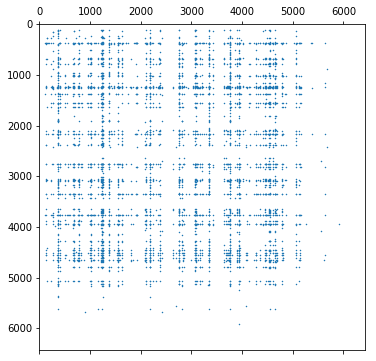

In [36]:
row=segments['ORIGIN_INDEX']
column=segments['DEST_INDEX']
value=segments['WEIGHT']
num=len(airport_codes)
from scipy.sparse import coo_matrix
P=coo_matrix((value, (row, column)), shape=(num, num))

# Visually inspect your result:
spy(P)

In [37]:
# Test cell: `P_test`

assert type(P) is sp.sparse.coo.coo_matrix, \
       "Matrix object has type {}, and is not a Numpy COO sparse matrix.".format(type(P))
assert P.shape == (n_airports, n_airports), "Matrix has the wrong shape: it is {} x {} instead of {} x {}".format(P.shape[0], P.shape[1], n_airports, n_airports)

# Check row sums, which must be either 0 or 1
n = P.shape[0]
u = np.ones(n)
row_sums = P.dot(u)
is_near_zero = np.isclose(row_sums, 0.0, atol=10*n*np.finfo(float).eps)
is_near_one = np.isclose(row_sums, 1.0, atol=10*n*np.finfo(float).eps)
assert (is_near_zero | is_near_one).all()
assert sum(is_near_one) == n_actual

print("\n(Passed!)")


(Passed!)


> **Note: Other formats.** The preceding code asked you to use coordinate ("COO") format to store the matrix. However, you may sometimes need to convert or use other formats. For example, SciPy provides many general graph processing algorithms in its [`csgraph` submodule](https://docs.scipy.org/doc/scipy/reference/sparse.csgraph.html). These routines expect the input graph as a sparse matrix, but one stored in compressed sparse row ("CSR") format rather than COO.

## Part 2, analysis: Computing the steady-state distribution

Armed with the state-transition matrix $P$, you can now compute the steady-state distribution.

**Exercise 7** (1 point). At time $t=0$, suppose the random flyer is equally likely to be at any airport with an outbound segment, i.e., the flyer is at one of the "actual" origins. Create a NumPy vector `x0[:]` such that `x0[i]` equals this initial probability of being at airport `i`.

> Note: If some airport $i$ has _no_ outbound flights, then be sure that $x_i(0) = 0$.

In [48]:
# Your task: Create `x0` as directed above.

##
## YOUR CODE HERE
##

All_zero=np.zeros(P.shape[0])
All_zero[np.unique(row)]=1/len(np.unique(row))
x0=All_zero
# Visually inspect your result:
def display_vec_sparsely(x, name='x'):
    i_nz = np.argwhere(x).flatten()
    df_x_nz = pd.DataFrame({'i': i_nz, '{}[i] (non-zero only)'.format(name): x[i_nz]})
    display(df_x_nz.head())
    print("...")
    display(df_x_nz.tail())
    
display_vec_sparsely(x0, name='x0')

,i,x0[i] (non-zero only)
0,119,0.003333
1,124,0.003333
2,125,0.003333
3,130,0.003333
4,138,0.003333


...


,i,x0[i] (non-zero only)
295,5565,0.003333
296,5612,0.003333
297,5630,0.003333
298,5685,0.003333
299,5908,0.003333


In [49]:
# Test cell: `x0_test`

assert type(x0) is np.ndarray, "`x0` does not appear to be a Numpy array."
assert np.isclose(x0.sum(), 1.0, atol=10*n*np.finfo(float).eps), "`x0` does not sum to 1.0, but it should."
assert np.isclose(x0.max(), 1.0/n_actual, atol=10*n*np.finfo(float).eps), "`x0` values seem off..."

print("\n(Passed!)")


(Passed!)


**Exercise 8** (2 points). Given the state-transition matrix `P`, an initial vector `x0`, and the number of time steps `t_max`, complete the function `eval_markov_chain(P, x0, t_max)` so that it computes and returns $x(t_{\textrm{max}})$.

In [54]:
def eval_markov_chain(P, x0, t_max):
    ###
    ### YOUR CODE HERE
    ###
    for i in range(t_max):
        x0=(P.T).dot(x0)
    return x0

T_MAX = 50
x = eval_markov_chain(P, x0, T_MAX)
display_vec_sparsely(x)

print("\n=== Top 10 airports ===\n")
ranks = np.argsort(-x)
top10 = pd.DataFrame({'Rank': np.arange(1, 11),
                      'Code': airport_codes.iloc[ranks[:10]]['Code'],
                      'Description': airport_codes.iloc[ranks[:10]]['Description'],
                      'x(t)': x[ranks[:10]]})
top10[['x(t)', 'Rank', 'Code', 'Description']]

,i,x[i] (non-zero only)
0,119,0.000721
1,124,0.005492
2,125,0.000237
3,130,0.000238
4,138,0.000715


...


,i,x[i] (non-zero only)
295,5565,0.000472
296,5612,0.000239
297,5630,0.001889
298,5685,0.000465
299,5908,0.000239



=== Top 10 airports ===



,x(t),Rank,Code,Description
373,0.037384,1,10397,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern..."
3770,0.036042,2,13930,"Chicago, IL: Chicago O'Hare International"
1245,0.031214,3,11292,"Denver, CO: Denver International"
3347,0.026761,4,13487,"Minneapolis, MN: Minneapolis-St Paul Internati..."
2177,0.024809,5,12266,"Houston, TX: George Bush Intercontinental/Houston"
1250,0.024587,6,11298,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter..."
1375,0.024483,7,11433,"Detroit, MI: Detroit Metro Wayne County"
3941,0.021018,8,14107,"Phoenix, AZ: Phoenix Sky Harbor International"
4646,0.020037,9,14869,"Salt Lake City, UT: Salt Lake City International"
1552,0.019544,10,11618,"Newark, NJ: Newark Liberty International"


In [55]:
PT_csr = P.T.tocsr()
row_start, row_end = PT_csr.indptr[124], PT_csr.indptr[125]
J = PT_csr.indices[row_start:row_end]
V = PT_csr.data[row_start:row_end]
print(row_start, row_end)
print(J)
print(V)
print(x0[J])
print(sum(x0[J] * V))

3 26
[ 373  399  792 1214 1245 1250 2106 2177 2381 2762 2765 3064 3070 3098
 3347 3644 3770 3892 3941 4459 4525 4549 4646]
[0.00636943 0.02325581 0.01587302 0.01818182 0.00763359 0.00970874
 0.0212766  0.00961538 0.01754386 0.01315789 0.01315789 0.025
 0.01408451 0.01538462 0.00884956 0.02631579 0.00666667 0.02083333
 0.01136364 0.01923077 0.01369863 0.0125     0.01190476]
[0.00333333 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333
 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333
 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333
 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333]
0.0011386876565065175


In [56]:
# Test cell: `eval_markov_chain_test`

print(x.sum())
assert np.isclose(x.sum(), 1.0, atol=T_MAX*n_actual*np.finfo(float).eps)

print("\nTop 10 airports by Markov chain analysis:\n", list(top10['Code']))
print("\nCompare that to the Top 10 by (historical) outbound segments:\n", list(origins_top10['ID']))

A = set(top10['Code'])
B = set(origins_top10['ID'])
C = (A - B) | (B - A)
C
# print("\nAirports that appear in one list but not the other:\n{}".format(C))
# assert C == {11618, 11433, 12266, 14771, 14869, 12889, 14747, 12892}

# print("\n(Passed!)")

0.9999999999999994

Top 10 airports by Markov chain analysis:
 [10397, 13930, 11292, 13487, 12266, 11298, 11433, 14107, 14869, 11618]

Compare that to the Top 10 by (historical) outbound segments:
 [10397, 13930, 11292, 12892, 14771, 11298, 14747, 12889, 14107, 13487]


{11433, 11618, 12266, 12889, 12892, 14747, 14771, 14869}

In [57]:
# Test cell: `eval_markov_chain_test`

print(x.sum())
assert np.isclose(x.sum(), 1.0, atol=T_MAX*n_actual*np.finfo(float).eps)

print("\nTop 10 airports by Markov chain analysis:\n", list(top10['Code']))
print("\nCompare that to the Top 10 by (historical) outbound segments:\n", list(origins_top10['ID']))

A = set(top10['Code'])
B = set(origins_top10['ID'])
C = (A - B) | (B - A)
print("\nAirports that appear in one list but not the other:\n{}".format(C))
assert C == {11618, 11433, 12266, 14771, 14869, 12889, 14747, 12892}

print("\n(Passed!)")

0.9999999999999994

Top 10 airports by Markov chain analysis:
 [10397, 13930, 11292, 13487, 12266, 11298, 11433, 14107, 14869, 11618]

Compare that to the Top 10 by (historical) outbound segments:
 [10397, 13930, 11292, 12892, 14771, 11298, 14747, 12889, 14107, 13487]

Airports that appear in one list but not the other:
{11618, 11433, 12266, 14771, 14869, 12889, 14747, 12892}

(Passed!)


**Comparing the two rankings.** Before ending this notebook, let's create a table that compares our two rankings, side-by-side, where the first ranking is the result of the Markov chain analysis and the second from a ranking based solely on number of segments.

In [58]:
top10_with_ranks = top10[['Code', 'Rank', 'Description']].copy()

origins_top10_with_ranks = origins_top10[['ID', 'Description']].copy()
origins_top10_with_ranks.rename(columns={'ID': 'Code'}, inplace=True)
origins_top10_with_ranks['Rank'] = origins_top10.index + 1
origins_top10_with_ranks = origins_top10_with_ranks[['Code', 'Rank', 'Description']]

top10_compare = top10_with_ranks.merge(origins_top10_with_ranks, how='outer', on='Code',
                                       suffixes=['_MC', '_Seg'])
top10_compare

,Code,Rank_MC,Description_MC,Rank_Seg,Description_Seg
0,10397,1.0,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",1.0,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern..."
1,13930,2.0,"Chicago, IL: Chicago O'Hare International",2.0,"Chicago, IL: Chicago O'Hare International"
2,11292,3.0,"Denver, CO: Denver International",3.0,"Denver, CO: Denver International"
3,13487,4.0,"Minneapolis, MN: Minneapolis-St Paul Internati...",10.0,"Minneapolis, MN: Minneapolis-St Paul Internati..."
4,12266,5.0,"Houston, TX: George Bush Intercontinental/Houston",NaN,NaN
5,11298,6.0,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",6.0,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter..."
6,11433,7.0,"Detroit, MI: Detroit Metro Wayne County",NaN,NaN
7,14107,8.0,"Phoenix, AZ: Phoenix Sky Harbor International",9.0,"Phoenix, AZ: Phoenix Sky Harbor International"
8,14869,9.0,"Salt Lake City, UT: Salt Lake City International",NaN,NaN
9,11618,10.0,"Newark, NJ: Newark Liberty International",NaN,NaN


**Fin!** That's it! You've determined the top 10 airports at which a random flyer ends up, assuming he or she randomly selects directly reachable destinations. How does it compare, qualitatively, to a ranking based instead on (historical) outbound segments? Which ranking is a better measure of importance to the overall airport network?

Be sure to submit this notebook to get credit for it.